In [1]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive # Import only if you are using Google Colab

In [2]:
df_train = pd.read_csv('df_1980_2020.csv', sep = ',', decimal = '.')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19111 entries, 0 to 19110
Data columns (total 56 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   19111 non-null  object 
 1   Pos      19111 non-null  object 
 2   Age      19111 non-null  int64  
 3   Tm       19111 non-null  object 
 4   G        19111 non-null  int64  
 5   GS       19111 non-null  int64  
 6   MP       19111 non-null  float64
 7   FG       19111 non-null  float64
 8   FGA      19111 non-null  float64
 9   FG%      19111 non-null  float64
 10  3P       19111 non-null  float64
 11  3PA      19111 non-null  float64
 12  3P%      19111 non-null  float64
 13  2P       19111 non-null  float64
 14  2PA      19111 non-null  float64
 15  2P%      19111 non-null  float64
 16  eFG%     19111 non-null  float64
 17  FT       19111 non-null  float64
 18  FTA      19111 non-null  float64
 19  FT%      19111 non-null  float64
 20  ORB      19111 non-null  float64
 21  DRB      191

In [4]:
df_train['Wins'] = df_train.Overall.apply(lambda x: x.split('-')[0]).astype(int)
df_train['Losses'] = df_train.Overall.apply(lambda x: x.split('-')[1]).astype(int)
df_train['W/L%'] = df_train.Wins / (df_train.Wins + df_train.Losses)

df_train['GS%'] = df_train.GS / df_train.G
df_train['GP%'] = df_train.G / (df_train.Wins + df_train.Losses)

df_train['MVP Rank'] = df_train.groupby('Season')['Pts Won'].rank(ascending = False, method = 'dense')
df_train['Won MVP'] = np.where(df_train['MVP Rank'] == 1, 1, 0)

In [5]:
df_train.tail()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,First,Pts Won,Pts Max,Share,Rk,Overall,Wins,Losses,W/L%,GS%,GP%,MVP Rank,Won MVP
19106,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,3.4,9.5,0.361,5.7,11.4,0.501,0.519,8.0,9.3,0.860,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6,2020,23.9,0.595,0.455,0.448,1.6,11.5,6.5,45.6,1.4,0.3,16.2,34.9,5.3,0.6,5.9,0.133,6.2,-2.3,3.9,3.1,0,0,0,0.0,26,20-47,20,47,0.298507,1.000000,0.895522,13.0,0
19107,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.524,0.3,1.3,0.240,4.0,7.0,0.577,0.543,2.1,3.1,0.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1,2020,18.8,0.576,0.157,0.374,12.6,21.2,16.7,11.3,1.5,1.7,11.9,20.8,2.3,1.3,3.6,0.129,0.2,-0.8,-0.6,0.5,0,0,0,0.0,23,23-42,23,42,0.353846,0.672414,0.892308,13.0,0
19108,Tyler Zeller,C,30,SAS,2,0,2.0,0.5,2.0,0.250,0.0,0.0,0.000,0.5,2.0,0.250,0.250,0.0,0.0,0.000,1.5,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2020,22.4,0.250,0.000,0.000,80.9,26.9,53.9,0.0,0.0,0.0,0.0,43.2,0.0,0.0,0.0,-0.075,-0.3,-22.1,-22.4,0.0,0,0,0,0.0,19,32-39,32,39,0.450704,0.000000,0.028169,13.0,0
19109,Ante Žižić,C,23,CLE,22,0,10.0,1.9,3.3,0.569,0.0,0.0,0.000,1.9,3.3,0.569,0.569,0.6,0.9,0.737,0.8,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4,2020,16.4,0.597,0.000,0.264,9.0,24.4,16.6,4.2,1.5,1.9,11.1,17.5,0.3,0.2,0.5,0.106,-1.7,-1.5,-3.2,-0.1,0,0,0,0.0,28,19-46,19,46,0.292308,0.000000,0.338462,13.0,0
19110,Ivica Zubac,C,22,LAC,72,70,18.4,3.3,5.3,0.613,0.0,0.0,0.000,3.3,5.3,0.616,0.613,1.7,2.3,0.747,2.7,4.8,7.5,1.1,0.2,0.9,0.8,2.3,8.3,2020,21.7,0.651,0.005,0.431,15.9,26.4,21.3,9.1,0.6,4.4,11.8,16.4,4.4,2.3,6.6,0.241,1.9,0.9,2.8,1.6,0,0,0,0.0,4,49-23,49,23,0.680556,0.972222,1.000000,13.0,0


In [6]:
corr = df_train.corr(method = 'pearson')
won_mvp_corr = corr[['Won MVP']]
won_mvp_corr['Won MVP'].abs().sort_values()

ORB%        0.001971
3PAr        0.007123
Season      0.007830
TOV%        0.012957
Age         0.013430
BLK%        0.014957
3P%         0.017698
FTr         0.019898
STL%        0.020583
PF          0.024407
FT%         0.026428
TRB%        0.028021
eFG%        0.029737
2P%         0.030624
FG%         0.031512
DRB%        0.037249
TS%         0.039077
3PA         0.043093
3P          0.044994
OBPM        0.047829
G           0.049611
GP%         0.049865
DBPM        0.051241
ORB         0.054301
BPM         0.055875
BLK         0.068644
GS%         0.070126
Rk          0.071751
Losses      0.073789
Wins        0.074346
AST%        0.075538
W/L%        0.076017
MP          0.078893
WS/48       0.083676
GS          0.085250
STL         0.087542
TRB         0.094399
USG%        0.094822
AST         0.107452
DRB         0.107502
PER         0.108559
TOV         0.111627
2PA         0.121173
FGA         0.122489
2P          0.133230
FG          0.135866
PTS         0.143236
DWS         0

In [7]:
df_train.Player.count()

19111

In [8]:
df_train_filtered = df_train[df_train['Pts Won'] > 0]
df_train_filtered.Player.count()

665

In [9]:
corr = df_train_filtered.corr(method = 'pearson')
won_mvp_corr = corr[['Won MVP']]
won_mvp_corr['Won MVP'].abs().sort_values()

ORB%        0.000665
ORB         0.012516
Pts Max     0.018585
Age         0.032404
BLK%        0.033425
Season      0.039551
FTr         0.040340
TOV%        0.041222
3P%         0.041356
3PAr        0.042820
GS%         0.046133
STL%        0.049110
BLK         0.050002
STL         0.064951
3PA         0.070115
TRB%        0.073317
GS          0.076909
3P          0.078135
G           0.079932
FG%         0.080351
FT%         0.086777
DRB%        0.092924
GP%         0.096390
TRB         0.097643
MP          0.102029
PF          0.103916
AST         0.105574
2P%         0.115179
eFG%        0.123226
AST%        0.123564
DRB         0.130524
2PA         0.132908
TOV         0.140403
TS%         0.158148
2P          0.167523
FTA         0.169279
FGA         0.177541
FT          0.195539
USG%        0.196267
DBPM        0.201908
DWS         0.208722
FG          0.217755
PTS         0.238142
Rk          0.240790
Wins        0.252158
Losses      0.265695
W/L%        0.276278
OWS         0

In [10]:
def plot_two_variables(df, title, var1, var1_order, var2, var2_order):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots()

    mvp = df[df['Won MVP'] == 1]
    non_mvp = df[df['Won MVP'] != 1]

    ax.scatter(mvp[var1], mvp[var2], label = 'MVP', marker = '^', s = 100)
    ax.scatter(non_mvp[var1], non_mvp[var2], label = 'Not MVP', alpha = .2)

    ax.legend(loc = 'best', prop = {'size': 12})

    ax.set_xlabel(var1, fontsize = 16)
    ax.set_ylabel(var2, fontsize = 16)

    ax.set_xlim(ax.get_xlim()[::var1_order])
    ax.set_ylim(ax.get_ylim()[::var2_order])

    fig.suptitle(title, weight = 'bold', size = 20)

    fig.text(x = -0.02, y = -0.08,
        s = '_______________________________________________________',
        fontsize = 16, color = 'grey', horizontalalignment = 'left', alpha = .2)

    fig.text(x = -0.02, y = -0.16,
        s = 'https://devcbc.github.io',
        fontsize = 16, color = 'grey', horizontalalignment = 'left')

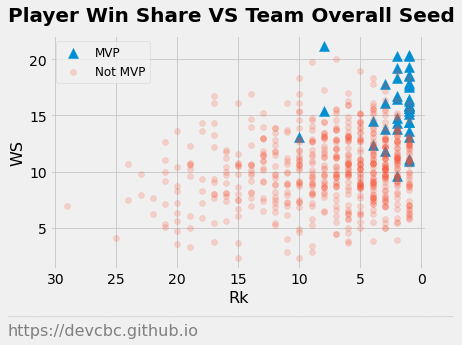

In [11]:
plot_two_variables(df_train_filtered, 'Player Win Share VS Team Overall Seed', 'Rk', -1, 'WS', 1)

In [12]:
df_train_filtered[(df_train_filtered['Won MVP'] == 1) & (df_train_filtered['Rk'] > 5)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
862,Moses Malone,HOU,42.0,31.1,14.7,1.8,0.9,1.5,0.519,0.000,0.762,15.4,0.218,1982,8,46-36,0.560976
2905,Michael Jordan,CHI,40.4,35.0,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988,8,50-32,0.609756
17260,Russell Westbrook,OKC,34.6,31.6,10.7,10.4,1.6,0.4,0.425,0.343,0.845,13.1,0.224,2017,10,47-35,0.573171


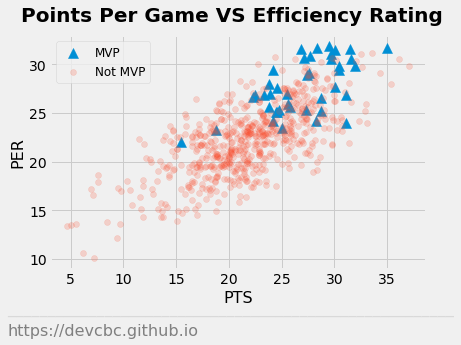

In [13]:
plot_two_variables(df_train_filtered, 'Points Per Game VS Efficiency Rating', 'PTS', 1, 'PER', 1)

In [14]:
df_train_filtered[(df_train_filtered['Won MVP'] == 1) & (df_train_filtered['PTS'] <= 20)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
10781,Steve Nash,PHO,34.3,15.5,3.3,11.5,1.0,0.1,0.502,0.431,0.887,10.9,0.203,2005,1,62-20,0.756098
11294,Steve Nash,PHO,35.4,18.8,4.2,10.5,0.8,0.2,0.512,0.439,0.921,12.4,0.212,2006,4,54-28,0.658537


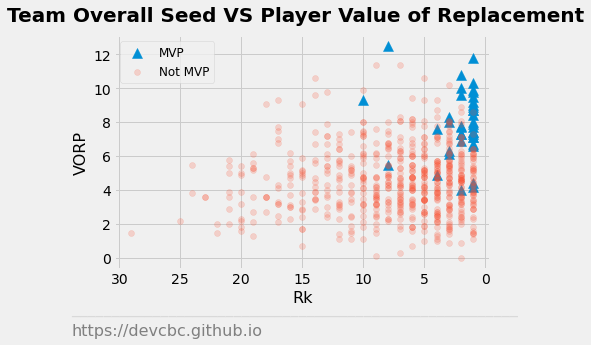

In [15]:
plot_two_variables(df_train_filtered, 'Team Overall Seed VS Player Value of Replacement', 'Rk', -1, 'VORP', 1)

In [16]:
def build_features(df_train, df_test):
    mms = MinMaxScaler()

    x_train_mms = mms.fit_transform(df_train[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                              'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                              'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                              'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                              'Wins', 'Losses', 'W/L%', 'GS%', 'GP%']])

    x_test_mms = mms.transform(df_test[['ORB%', 'ORB', 'BLK%', 'FTr', 'Age', 'TOV%', '3P%', '3PAr', 'BLK', 'STL%', 'GS', 'TRB%',
                                        'STL', 'FG%', '3PA', 'DRB%', 'G', '3P', 'TRB', 'FT%', '2P%', 'AST', 'PF', 'MP',
                                        'eFG%', 'DRB', 'AST%', '2PA', 'TOV', 'TS%', '2P', 'FTA', 'FGA', 'USG%', 'DBPM', 'FT',
                                        'DWS', 'FG', 'PTS', 'Rk', 'OBPM', 'OWS', 'PER', 'BPM', 'WS/48', 'VORP', 'WS',
                                        'Wins', 'Losses', 'W/L%', 'GS%', 'GP%']])

    x_train = np.hstack([x_train_mms])
    x_test = np.hstack([x_test_mms])

    y_train = df_train['Won MVP'].values.reshape(-1, 1)
    y_test = df_test['Won MVP'].values.reshape(-1, 1)

    return x_train, y_train, x_test, y_test

In [17]:
model = LogisticRegression(solver = 'liblinear')

In [18]:
df_train_predicted = []
results_matrix = np.zeros(shape = (1, 2020 - 1980, 4, 2))
for season in range(1980, 2021):
    fold = season - 1980 - 1
    df_train = df_train_filtered[df_train_filtered.Season != season]
    df_test = df_train_filtered[df_train_filtered.Season == season]

    x_train, y_train, x_test, y_test = build_features(df_train, df_test)

    model.fit(x_train, y_train)

    df_train_rank = df_train.copy()
    df_train_rank['MVP Odds'] = model.predict_proba(x_train)[:, 1]

    df_train_rank['Predicted MVP Rank'] = df_train_rank.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')

    df_train_rank['Predicted MVP Winner'] = df_train_rank['Predicted MVP Rank']
    df_train_rank['Predicted MVP Winner'].loc[df_train_rank['Predicted MVP Winner'] != 1] = 0

    df_train_rank_won_mvp = df_train_rank['Won MVP']
    df_train_rank_predicted_mvp_winner = df_train_rank['Predicted MVP Winner']

    results_matrix[0, fold, 0, 0] = metrics.accuracy_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 1, 0] = metrics.precision_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 2, 0] = metrics.recall_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 3, 0] = metrics.f1_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)

    df_test_rank = df_test.copy()
    df_test_rank['MVP Odds'] = model.predict_proba(x_test)[:, 1]

    df_train_predicted.append(df_test_rank)

    df_test_rank['Predicted MVP Rank'] = df_test_rank.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')

    df_test_rank['Predicted MVP Winner'] = df_test_rank['Predicted MVP Rank']
    df_test_rank['Predicted MVP Winner'].loc[df_test_rank['Predicted MVP Winner'] != 1] = 0

    df_test_rank_won_mvp = df_test_rank['Won MVP']
    df_test_rank_predicted_mvp_winner = df_test_rank['Predicted MVP Winner']

    results_matrix[0, fold, 0, 1] = metrics.accuracy_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 1, 1] = metrics.precision_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 2, 1] = metrics.recall_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 3, 1] = metrics.f1_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)

In [19]:
print('Algorithm: Logistic Regression')
print()
print('Train')
print('Accuracy:', results_matrix[0, :, 0, 0].mean())
print('Precision:', results_matrix[0, :, 1, 0].mean())
print('Coverage:', results_matrix[0, :, 2, 0].mean())
print('F Measure:', results_matrix[0, :, 3, 0].mean())
print()
print('Test')
print('Accuracy:', results_matrix[0, :, 0, 1].mean())
print('Precision:', results_matrix[0, :, 1, 1].mean())
print('Coverage:', results_matrix[0, :, 2, 1].mean())
print('F Measure:', results_matrix[0, :, 3, 1].mean())

Algorithm: Logistic Regression

Train
Accuracy: 0.9703201884925161
Precision: 0.759375
Coverage: 0.759375
F Measure: 0.759375

Test
Accuracy: 0.962096742520604
Precision: 0.7
Coverage: 0.7
F Measure: 0.7


In [20]:
df_train_predicted = pd.concat(df_train_predicted)

In [21]:
df_train_predicted[(df_train_predicted['Won MVP'] == 1) & (df_train_predicted['Predicted MVP Winner'] != 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%', 'Predicted MVP Rank']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%,Predicted MVP Rank
411,Julius Erving,PHI,35.0,24.6,8.0,4.4,2.1,1.8,0.521,0.222,0.787,13.8,0.231,1981,2,62-20,0.756098,6.0
862,Moses Malone,HOU,42.0,31.1,14.7,1.8,0.9,1.5,0.519,0.000,0.762,15.4,0.218,1982,8,46-36,0.560976,4.0
2905,Michael Jordan,CHI,40.4,35.0,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988,8,50-32,0.609756,2.0
4803,Charles Barkley,PHO,37.6,25.6,12.2,5.1,1.6,1.0,0.520,0.305,0.765,14.4,0.242,1993,1,62-20,0.756098,2.0
5501,Hakeem Olajuwon,HOU,41.0,27.3,11.9,3.6,1.6,3.7,0.528,0.421,0.716,14.3,0.210,1994,2,58-24,0.707317,2.0
6828,Karl Malone,UTA,36.6,27.4,9.9,4.5,1.4,0.6,0.550,0.000,0.755,16.7,0.268,1997,2,64-18,0.780488,2.0
8710,Allen Iverson,PHI,42.0,31.1,3.8,4.6,2.5,0.3,0.420,0.320,0.814,11.8,0.190,2001,3,56-26,0.682927,4.0
10781,Steve Nash,PHO,34.3,15.5,3.3,11.5,1.0,0.1,0.502,0.431,0.887,10.9,0.203,2005,1,62-20,0.756098,7.0
11294,Steve Nash,PHO,35.4,18.8,4.2,10.5,0.8,0.2,0.512,0.439,0.921,12.4,0.212,2006,4,54-28,0.658537,8.0
12040,Kobe Bryant,LAL,38.9,28.3,6.3,5.4,1.8,0.5,0.459,0.361,0.840,13.8,0.208,2008,3,57-25,0.695122,6.0


In [22]:
df_train_predicted[(df_train_predicted['Won MVP'] != 1) & (df_train_predicted['Predicted MVP Winner'] == 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%', 'MVP Rank']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%,MVP Rank
323,Kareem Abdul-Jabbar,LAL,37.2,26.2,10.3,3.4,0.7,2.9,0.574,0.000,0.766,14.3,0.230,1981,5,54-28,0.658537,3.0
673,Larry Bird,BOS,38.0,22.9,10.9,5.8,1.9,0.9,0.503,0.212,0.863,12.5,0.205,1982,1,63-19,0.768293,2.0
2761,Larry Bird,BOS,39.0,29.9,9.3,6.1,1.6,0.8,0.527,0.414,0.916,15.0,0.243,1988,2,57-25,0.695122,2.0
4964,Michael Jordan,CHI,39.3,32.6,6.7,5.5,2.8,0.8,0.495,0.352,0.837,17.2,0.270,1993,3,57-25,0.695122,3.0
5542,David Robinson,SAS,40.5,29.8,10.7,4.8,1.7,3.3,0.507,0.345,0.749,20.0,0.296,1994,7,55-27,0.670732,2.0
6786,Michael Jordan,CHI,37.9,29.6,5.9,4.3,1.7,0.5,0.486,0.374,0.833,18.3,0.283,1997,1,69-13,0.841463,2.0
8837,Shaquille O'Neal,LAL,39.5,28.7,12.7,3.7,0.6,2.8,0.572,0.000,0.513,14.9,0.245,2001,2,56-26,0.682927,3.0
10580,Tim Duncan,SAS,33.4,20.3,11.1,2.7,0.7,2.6,0.496,0.333,0.670,11.2,0.245,2005,3,59-23,0.719512,4.0
11301,Dirk Nowitzki,DAL,38.1,26.6,9.0,2.8,0.7,1.0,0.480,0.406,0.901,17.7,0.275,2006,3,60-22,0.731707,3.0
12339,Chris Paul,NOH,37.6,21.1,4.0,11.6,2.7,0.1,0.488,0.369,0.851,17.8,0.284,2008,4,56-26,0.682927,2.0


In [23]:
df_train_predicted[(df_train_predicted['Won MVP'] == 1) & (df_train_predicted['Predicted MVP Winner'] == 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
0,Kareem Abdul-Jabbar,LAL,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,2,60-22,0.731707
1203,Moses Malone,PHI,37.5,24.5,15.3,1.3,1.1,2.0,0.501,0.000,0.761,15.1,0.248,1983,1,65-17,0.792683
1372,Larry Bird,BOS,38.3,24.2,10.1,6.6,1.8,0.9,0.492,0.247,0.888,13.6,0.215,1984,1,62-20,0.756098
1700,Larry Bird,BOS,39.5,28.7,10.5,6.6,1.6,1.2,0.522,0.427,0.882,15.7,0.238,1985,1,63-19,0.768293
2044,Larry Bird,BOS,38.0,25.8,9.8,6.8,2.0,0.6,0.496,0.423,0.896,15.8,0.244,1986,1,67-15,0.817073
2526,Magic Johnson,LAL,36.3,23.9,6.3,12.2,1.7,0.5,0.522,0.205,0.848,15.9,0.263,1987,1,65-17,0.792683
3282,Magic Johnson,LAL,37.5,22.5,7.9,12.8,1.8,0.3,0.509,0.314,0.911,16.1,0.267,1989,3,57-25,0.695122
3690,Magic Johnson,LAL,37.2,22.3,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990,1,63-19,0.768293
4127,Michael Jordan,CHI,37.0,31.5,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,1991,2,61-21,0.743902
4551,Michael Jordan,CHI,38.8,30.1,6.4,6.1,2.3,0.9,0.519,0.270,0.832,17.7,0.274,1992,1,67-15,0.817073


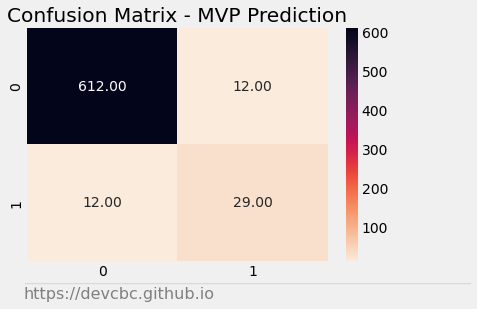

In [24]:
predicted = df_train_predicted['Predicted MVP Winner']
ground_truth = df_train_predicted['Won MVP']

cm = confusion_matrix(ground_truth, predicted)

plt.title('Confusion Matrix - MVP Prediction')
sns.heatmap(cm, annot = True, fmt = '.2f', cmap = 'rocket_r')

plt.text(x = -0.02, y = 2.16,
    s = '_______________________________________________________',
    fontsize = 16, color = 'grey', horizontalalignment = 'left', alpha = .2)

plt.text(x = -0.02, y = 2.32,
    s = 'https://devcbc.github.io',
    fontsize = 16, color = 'grey', horizontalalignment = 'left')

plt.show()

In [25]:
df_production = pd.read_csv('df_2021.csv', sep = ',', decimal = '.')

In [26]:
df_production['Wins'] = df_production.Overall.apply(lambda x: x.split('-')[0]).astype(int)
df_production['Losses'] = df_production.Overall.apply(lambda x: x.split('-')[1]).astype(int)
df_production['W/L%'] = df_production.Wins / (df_production.Wins + df_production.Losses)

df_production['GS%'] = df_production.GS / df_production.G
df_production['GP%'] = df_production.G / (df_production.Wins + df_production.Losses)

df_production['Won MVP'] = 0

In [27]:
df_production.Player.count()

626

In [28]:
df_production = df_production[(df_production['GS%'] > 0.9) & (df_production['GP%'] > 0.7)]

In [29]:
df_production.Player.count()

82

In [30]:
x_train, y_train, x_test, y_test = build_features(df_train_filtered, df_production)
x_complete = x_train
y_complete = y_train

model.fit(x_complete, y_complete)

df_production['MVP Odds'] = model.predict_proba(x_test)[:, 1]

df_production['Predicted MVP Rank'] = df_production.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')

df_production['Predicted MVP Winner'] = df_production['Predicted MVP Rank']
df_production['Predicted MVP Winner'].loc[df_production['Predicted MVP Winner'] != 1] = 0

In [31]:
df_production.sort_values(by = ['Predicted MVP Rank'], ascending = True)[['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%', 'MVP Odds']].head(10)

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%,MVP Odds
304,Nikola Jokić,DEN,34.6,26.4,10.8,8.3,1.3,0.7,0.566,0.388,0.868,15.6,0.301,2021,5,47-25,0.652778,0.299249
168,Joel Embiid,PHI,31.1,28.5,10.6,2.8,1.0,1.4,0.513,0.377,0.859,8.8,0.266,2021,3,49-23,0.680556,0.124500
14,Giannis Antetokounmpo,MIL,33.0,28.1,11.0,5.9,1.2,1.2,0.569,0.303,0.685,10.2,0.244,2021,7,46-26,0.638889,0.071054
343,Kawhi Leonard,LAC,34.1,24.8,6.5,5.2,1.6,0.4,0.512,0.398,0.885,8.8,0.238,2021,6,47-25,0.652778,0.052156
402,Donovan Mitchell,UTA,33.4,26.4,4.4,5.2,1.0,0.3,0.438,0.386,0.845,6.2,0.167,2021,1,52-20,0.722222,0.046566
151,Luka Dončić,DAL,34.3,27.7,8.0,8.6,1.0,0.5,0.479,0.350,0.730,7.7,0.163,2021,8,42-30,0.583333,0.034450
348,Damian Lillard,POR,35.8,28.8,4.2,7.5,0.9,0.3,0.451,0.391,0.928,10.4,0.209,2021,10,42-30,0.583333,0.031043
95,Jimmy Butler,MIA,33.6,21.5,6.9,7.1,2.1,0.3,0.497,0.245,0.863,9.3,0.255,2021,13,40-32,0.555556,0.028348
205,Rudy Gobert,UTA,30.8,14.3,13.5,1.3,0.6,2.7,0.675,0.000,0.623,11.3,0.248,2021,1,52-20,0.722222,0.024477
120,Mike Conley,UTA,29.4,16.2,3.5,6.0,1.4,0.2,0.444,0.412,0.852,6.1,0.197,2021,1,52-20,0.722222,0.022315
